In [2]:
# import table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import itertools as it
import json
%matplotlib inline

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.discovery.inductive.variants.im_f import algorithm as im_f_algo
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

from dpv.util.converter import param_transform, downscale, merge
from dpv.variant_transformer import private_transform, public_transform
from dpv.variant_query import variant_query
from dpv.optimizer import release_optimizer
from dpv.data_utility import emd_utility, log_diff

In [3]:
# import xes event log (BPIC13 example)
log = importer.apply('BPIC13.xes')

# process model from xes log
net1, im1, fm1 = im_f_algo.apply(log, parameters=None)

parsing log, completed traces ::   0%|          | 0/7554 [00:00<?, ?it/s]

In [4]:
# compute summary statistics for single release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # convert to p and k
        p, k = param_transform(eps, d)
        
        for i in range(10):

            # privatize variants            
            traces_orig, traces_priv = private_transform(log, p, k)

            # save results
            fp = open(f"variants_single_{eps}_{d}_{i}.json", "w")
            json.dump(traces_priv, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001
[+] eps: 0.001 delta: 0.5
[+] eps: 0.001 delta: 0.1
[+] eps: 0.001 delta: 0.05
[+] eps: 0.001 delta: 0.01
[+] eps: 0.001 delta: 0.001


In [158]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_single = np.zeros((len(eps_list), len(del_list)))
cost_single = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'single/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_single[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_single[m][n] = np.mean([x for x in tmp_cost if x != 75540])
        print(f'eps: {eps}, delta: {d}, util: {util_single[m][n]}, cost: {cost_single[m][n]}')
        
# save metrics
np.savetxt('single/util_single.txt', util_single)
np.savetxt('single/cost_single.txt', cost_single)

eps: 2, delta: 0.5, util: 0.9281671678861722, cost: 125599.6
eps: 2, delta: 0.1, util: 0.9020552514232699, cost: 171600.0
eps: 2, delta: 0.05, util: 0.903080158371172, cost: 172293.9
eps: 2, delta: 0.01, util: 0.8856013977119975, cost: 196135.6
eps: 2, delta: 0.001, util: 0.8803175170550646, cost: 214923.9
eps: 1, delta: 0.5, util: 0.9462907871834695, cost: 95696.4
eps: 1, delta: 0.1, util: 0.9170916220931729, cost: 146154.0
eps: 1, delta: 0.05, util: 0.8968542759518057, cost: 178746.9
eps: 1, delta: 0.01, util: 0.8854535147749878, cost: 203394.9
eps: 1, delta: 0.001, util: 0.862317458686886, cost: 250244.1
eps: 0.1, delta: 0.5, util: 0.9654043467618691, cost: 61451.6
eps: 0.1, delta: 0.1, util: 0.930628602089621, cost: 114965.8
eps: 0.1, delta: 0.05, util: 0.9141617121928081, cost: 150998.1
eps: 0.1, delta: 0.01, util: 0.8729982186457749, cost: 235823.7
eps: 0.1, delta: 0.001, util: 0.8185056415356771, cost: 338764.5
eps: 0.01, delta: 0.5, util: 0.9661072090272687, cost: 57515.9
eps: 

In [4]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_single = np.zeros((len(eps_list), len(del_list)))
fit_single = np.zeros((len(eps_list), len(del_list)))
gen_single = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_single_avg = []
        fit_single_avg = []
        gen_single_avg = []

        for i in range(10):
            
            f = open(f'single/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_single_avg.append(prec)
            fit_single_avg.append(fit['log_fitness'])
            gen_single_avg.append(gen)
            
            f.close()
        
        # save results
        prec_single[m][n] = np.mean(prec_single_avg)
        fit_single[m][n] = np.mean(fit_single_avg)
        gen_single[m][n] = np.mean(gen_single_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_single[m][n]}, fit: {fit_single[m][n]}, gen: {gen_single[m][n]}')

# save metrics
np.savetxt('single/prec_single.txt', prec_single)
np.savetxt('single/fit_single.txt', fit_single)
np.savetxt('single/gen_single.txt', gen_single)

replaying log with TBR, completed variants ::   0%|          | 0/2126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/413 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/413 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2117 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/420 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/420 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1956 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/415 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/415 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2077 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/419 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/419 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1856 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/401 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/401 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2167 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/421 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/421 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1983 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/410 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/410 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2021 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/410 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/410 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/429 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/429 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/410 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/410 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.915037716983426, fit: 0.997290109316533, gen: 0.9817653294536877


replaying log with TBR, completed variants ::   0%|          | 0/821 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/679 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/558 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/682 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/647 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/223 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/223 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/747 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/701 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/222 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/222 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/712 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/221 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/221 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/846 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/237 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/237 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/622 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/211 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/211 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.919337595663689, fit: 0.9982380589013911, gen: 0.9760405491381409


replaying log with TBR, completed variants ::   0%|          | 0/759 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/796 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/798 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/608 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/213 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/213 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/846 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/586 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/212 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/212 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/694 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/723 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.9165593332041236, fit: 0.9982593793219954, gen: 0.976073277575739


replaying log with TBR, completed variants ::   0%|          | 0/397 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/404 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/373 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/407 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/432 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/425 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/476 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.921204970084297, fit: 0.9985979562296567, gen: 0.9711016779797108


replaying log with TBR, completed variants ::   0%|          | 0/299 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/124 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/124 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/316 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/290 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/315 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/318 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/302 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/122 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/122 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/291 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/122 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/122 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/293 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/123 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/123 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/289 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/121 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.9184454653246326, fit: 0.9988564640410897, gen: 0.9668834363423269


replaying log with TBR, completed variants ::   0%|          | 0/3400 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/529 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/529 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/510 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/510 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/527 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/527 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3600 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/551 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/551 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3065 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/535 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/535 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3062 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/501 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/501 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/572 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/572 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3210 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/540 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/540 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3440 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/531 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.8933633623594188, fit: 0.9964244445265813, gen: 0.9825277312137081


replaying log with TBR, completed variants ::   0%|          | 0/1437 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/290 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/290 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1407 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/293 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/293 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1302 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/278 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/278 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1529 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/287 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/287 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1223 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/269 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/269 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1493 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1481 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/284 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/284 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1465 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/286 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/286 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1324 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/290 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/290 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/285 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/285 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.8995361445213774, fit: 0.9973843566136253, gen: 0.9770631551212052


replaying log with TBR, completed variants ::   0%|          | 0/688 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/857 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/751 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/187 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/187 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/663 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/185 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/185 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/725 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/197 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/197 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/714 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/187 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/187 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/821 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/798 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/728 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/675 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/181 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/181 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.9081059014498454, fit: 0.9980963983557218, gen: 0.9723966666976528


replaying log with TBR, completed variants ::   0%|          | 0/414 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/454 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/145 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/145 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/448 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/397 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/134 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/134 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/503 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/470 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/424 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/136 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/136 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.9090374033373225, fit: 0.998595900688992, gen: 0.9679003976238064


replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/179 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/170 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/74 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/74 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/217 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/195 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/74 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/74 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/182 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/183 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/167 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/74 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/74 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/157 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/67 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/67 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.8601400619507489, fit: 0.9991704252205486, gen: 0.953566079181838


replaying log with TBR, completed variants ::   0%|          | 0/4482 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/627 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/627 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4332 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/648 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/648 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4451 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4271 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/650 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/650 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/649 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/649 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4636 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/660 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/660 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4059 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/616 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/616 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4534 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/678 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/678 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4979 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/682 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/682 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/695 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/695 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.875476619395893, fit: 0.9957555376103908, gen: 0.9831767769082791


replaying log with TBR, completed variants ::   0%|          | 0/1583 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1980 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1742 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1726 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/266 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/266 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1644 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1805 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/276 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/276 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1481 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1722 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/255 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/255 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1653 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1602 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/253 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/253 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.8591785606117524, fit: 0.9963342553888659, gen: 0.9718460292295299


replaying log with TBR, completed variants ::   0%|          | 0/1225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/180 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/180 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/900 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/954 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/917 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/909 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/157 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/157 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1003 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/165 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/165 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1056 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/178 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/178 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1006 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/929 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/958 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/169 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/169 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.8397416615283534, fit: 0.9964435898558677, gen: 0.9630856914799416


replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/272 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/202 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/276 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/315 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/68 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/68 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/254 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/287 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/212 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/65 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/65 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.7975707572480163, fit: 0.9975080167705412, gen: 0.9359232022599329


replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/28 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/28 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/132 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.7340978837462436, fit: 0.9990087815938853, gen: 0.8555582705969886


replaying log with TBR, completed variants ::   0%|          | 0/4708 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/670 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/670 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4710 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4670 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4790 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/687 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/687 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4769 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/646 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/646 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4870 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/706 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/706 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4730 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/666 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/666 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/664 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/664 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4845 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/645 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/645 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4756 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/670 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/670 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.8795275309538273, fit: 0.9954708099149034, gen: 0.9832473645907545


replaying log with TBR, completed variants ::   0%|          | 0/1673 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1661 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/237 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/237 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1626 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/238 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/238 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1406 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/240 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/240 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1555 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/247 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/247 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1527 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/233 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/233 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1435 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1524 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/238 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/238 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1786 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.8447320315981489, fit: 0.9962073410988429, gen: 0.9694275168173243


replaying log with TBR, completed variants ::   0%|          | 0/1078 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/141 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/141 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/832 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/136 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/136 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1015 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/785 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/990 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/137 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/137 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/153 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/153 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/788 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1130 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/772 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.8008198845222818, fit: 0.9962484577389741, gen: 0.9574604254310233


replaying log with TBR, completed variants ::   0%|          | 0/291 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/192 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/261 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/203 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/236 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.7196078286999534, fit: 0.9972520691671954, gen: 0.9118229457821458


replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/26 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/60 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.6723797432928974, fit: 0.9988334019992628, gen: 0.7349316542123123


replaying log with TBR, completed variants ::   0%|          | 0/4751 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/674 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/674 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4683 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/703 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/703 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4643 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4528 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/679 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/679 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4654 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/676 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/676 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4644 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/666 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/666 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4516 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4388 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4611 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/674 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/674 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.8777271717578989, fit: 0.9955021686931957, gen: 0.9832336270042298


replaying log with TBR, completed variants ::   0%|          | 0/1797 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1560 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1467 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/253 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/253 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1800 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/268 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/268 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1583 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/254 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/254 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1460 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1699 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/248 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/248 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1344 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/242 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.8488201958895388, fit: 0.9958965275066974, gen: 0.9695460532705583


replaying log with TBR, completed variants ::   0%|          | 0/1100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1002 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1032 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1096 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/888 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/972 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/796 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/872 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/839 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/137 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/137 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1007 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.8106166221965037, fit: 0.9962231597317999, gen: 0.9578097967641362


replaying log with TBR, completed variants ::   0%|          | 0/250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/248 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/178 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/201 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/286 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/246 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/280 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.7140078482579072, fit: 0.9962577832210288, gen: 0.9070680861611681


replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.5777323710289813, fit: 0.9972129326908259, gen: 0.645293567050197


In [151]:
# compute summary statistics for PINQ queries

# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
pruning = [[8, 10, 10, 10, 10],[13, 17, 18, 18, 19],[30, 85, 105, 142, 152],[35, 143, 245, 680, 1250]]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")
        
        for i in range(10):
            
            # privatize variant frequencies
            l = 0
            while l < 1100 or l > 1500:
                query_vars = variant_query(log, eps/25, cutoff=25, prune=pruning[m][n], delta=d/25)
                l = len(query_vars)
                
            # save results
            fp = open(f"variants_benchmark_{eps}_{d}_{i}.json", "w")
            json.dump(query_vars, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001


In [159]:
# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_bench = np.zeros((len(eps_list), len(del_list)))
cost_bench = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_bench[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_bench[m][n] = np.mean([x for x in tmp_cost if x != 75540])
        print(f'eps: {eps}, delta: {d}, util: {util_bench[m][n]}, cost: {cost_bench[m][n]}')
        
# save metrics
np.savetxt('benchmark/util_bench.txt', util_bench)
np.savetxt('benchmark/cost_bench.txt', cost_bench)

eps: 2, delta: 0.5, util: 0.6862152428657716, cost: 2819685.8
eps: 2, delta: 0.1, util: 0.6787338713184707, cost: 3059031.7
eps: 2, delta: 0.05, util: 0.6722829482258721, cost: 3451503.3
eps: 2, delta: 0.01, util: 0.6716400085466749, cost: 3465835.8
eps: 2, delta: 0.001, util: 0.6654677220684726, cost: 3539034.5
eps: 1, delta: 0.5, util: 0.6430891015468726, cost: 4949256.8
eps: 1, delta: 0.1, util: 0.6313961284230727, cost: 6194992.8
eps: 1, delta: 0.05, util: 0.6270195371591715, cost: 6761378.7
eps: 1, delta: 0.01, util: 0.6211145536716713, cost: 6954441.9
eps: 1, delta: 0.001, util: 0.6201394836312722, cost: 6932657.7
eps: 0.1, delta: 0.5, util: 0.5920233482560728, cost: 11904614.1
eps: 0.1, delta: 0.1, util: 0.5514513754202712, cost: 33221114.8
eps: 0.1, delta: 0.05, util: 0.5316955542307721, cost: 44590714.3
eps: 0.1, delta: 0.01, util: 0.5265677914624715, cost: 63960931.6
eps: 0.1, delta: 0.001, util: 0.5242804791173715, cost: 65355318.5
eps: 0.01, delta: 0.5, util: 0.584848534739

In [5]:
# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_bench = np.zeros((len(eps_list), len(del_list)))
fit_bench = np.zeros((len(eps_list), len(del_list)))
gen_bench = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_bench_avg = []
        fit_bench_avg = []
        gen_bench_avg = []

        for i in range(10):
            
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_bench_avg.append(prec)
            fit_bench_avg.append(fit['log_fitness'])
            gen_bench_avg.append(gen)
            
            f.close()
        
        # save results
        prec_bench[m][n] = np.mean(prec_bench_avg)
        fit_bench[m][n] = np.mean(fit_bench_avg)
        gen_bench[m][n] = np.mean(gen_bench_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_bench[m][n]}, fit: {fit_bench[m][n]}, gen: {gen_bench[m][n]}')

# save metrics
np.savetxt('benchmark/prec_bench.txt', prec_bench)
np.savetxt('benchmark/fit_bench.txt', fit_bench)
np.savetxt('benchmark/gen_bench.txt', gen_bench)

replaying log with TBR, completed variants ::   0%|          | 0/1311 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1328 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1328 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1181 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1181 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1292 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1374 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1374 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1412 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1412 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1399 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1112 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1215 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1215 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1445 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1198 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.8242435204088187, fit: 0.958013000746833, gen: 0.9816973624499934


replaying log with TBR, completed variants ::   0%|          | 0/1063 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1188 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1204 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1204 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1137 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1124 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1124 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1174 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1211 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1211 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1185 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1185 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1234 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1198 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1111 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1079 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1134 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1170 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1170 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.8195166726931596, fit: 0.955719502212723, gen: 0.9803805719377803


replaying log with TBR, completed variants ::   0%|          | 0/1120 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1173 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1173 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1423 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1452 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1452 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1185 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1177 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1177 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1223 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1132 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1132 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1401 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1444 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1444 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1301 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1380 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1380 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1267 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1334 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.8291362659430268, fit: 0.9551751182238366, gen: 0.9813227747510516


replaying log with TBR, completed variants ::   0%|          | 0/1168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1075 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1316 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1337 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1393 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1393 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1365 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1444 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1444 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1310 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1059 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1259 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1259 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.816985769362234, fit: 0.956003195686374, gen: 0.9808237200909351


replaying log with TBR, completed variants ::   0%|          | 0/1387 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1426 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1426 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1202 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1064 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1304 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1367 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1424 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1424 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1376 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1376 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1199 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1251 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1251 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1269 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1331 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1331 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1270 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1270 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.8286901730520693, fit: 0.9561644906422503, gen: 0.9813045836845037


replaying log with TBR, completed variants ::   0%|          | 0/1278 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1339 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1339 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1193 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1293 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1293 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1203 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1324 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1436 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1436 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1376 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1486 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1486 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1287 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1319 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1281 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1284 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1336 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1336 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.8069986585502328, fit: 0.952356441420083, gen: 0.9819712404090065


replaying log with TBR, completed variants ::   0%|          | 0/1201 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1036 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1125 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1248 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1248 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1016 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1289 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1289 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1286 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1286 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1445 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1445 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1071 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1210 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1210 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1187 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1302 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1302 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.811210303699512, fit: 0.9498077231338641, gen: 0.9811141480833975


replaying log with TBR, completed variants ::   0%|          | 0/1332 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1251 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1251 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1112 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1337 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1456 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1456 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1190 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/983 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1117 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1232 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1232 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1234 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1340 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.8032739697526721, fit: 0.9503047600962573, gen: 0.9817143799756642


replaying log with TBR, completed variants ::   0%|          | 0/1235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1332 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1332 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1041 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1035 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1285 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1435 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1435 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1407 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1407 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1352 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1352 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1107 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1029 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1379 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1493 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1493 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.7943188177291816, fit: 0.9505523709682878, gen: 0.9804091822060499


replaying log with TBR, completed variants ::   0%|          | 0/1067 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1043 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1337 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1337 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1236 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1236 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1069 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1253 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1067 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1117 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1117 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1349 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1438 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1438 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1261 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1261 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1331 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1450 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1450 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.8071415719818698, fit: 0.9513680775356621, gen: 0.9808920441949812


replaying log with TBR, completed variants ::   0%|          | 0/1361 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1271 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1271 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/981 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1120 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1120 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1488 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1488 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1095 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1226 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1226 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/983 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1120 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1120 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1412 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1412 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1322 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1279 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1010 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1104 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.7845671406136165, fit: 0.9476918996489783, gen: 0.9811916618002284


replaying log with TBR, completed variants ::   0%|          | 0/972 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1143 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1143 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1143 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1313 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1313 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1028 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1199 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1199 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1071 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1345 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1345 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1016 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1178 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1178 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/957 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1099 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/918 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1033 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1207 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1207 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.7559458107878532, fit: 0.9441514197716281, gen: 0.9802471125816993


replaying log with TBR, completed variants ::   0%|          | 0/955 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/927 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/954 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/918 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1112 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1112 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1088 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1022 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/941 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1131 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1131 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1223 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1455 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1455 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.7500511506349433, fit: 0.9439518030312744, gen: 0.9786367005199557


replaying log with TBR, completed variants ::   0%|          | 0/1092 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/973 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1164 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1405 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1405 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/957 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1202 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1459 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1459 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1018 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1157 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/901 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1460 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1460 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1490 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1490 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.752751350207741, fit: 0.9398955950492349, gen: 0.9802586724488531


replaying log with TBR, completed variants ::   0%|          | 0/1079 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1276 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1276 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/963 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1153 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1153 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/962 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1188 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1188 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1033 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1280 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1280 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1185 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1411 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1411 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1040 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1266 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1266 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1071 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1301 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1301 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1004 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1059 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1307 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.7563458900720222, fit: 0.9385038102467954, gen: 0.981639016992861


replaying log with TBR, completed variants ::   0%|          | 0/1048 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1199 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1034 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/954 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1110 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1110 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1208 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1405 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1405 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/964 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1500 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1500 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.7874426151094143, fit: 0.9458573717509602, gen: 0.9812314204494388


replaying log with TBR, completed variants ::   0%|          | 0/1075 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1030 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1228 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/979 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1172 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1172 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1206 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1456 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1456 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/935 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/955 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1040 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1284 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1284 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1216 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1440 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1440 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1356 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.7737308793325357, fit: 0.9414867684210677, gen: 0.9805042461079518


replaying log with TBR, completed variants ::   0%|          | 0/864 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1468 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1468 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/861 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1067 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1067 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1420 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1420 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1017 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/936 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/976 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1227 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1227 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1044 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1330 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1330 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/960 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1221 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1221 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.7429077733591837, fit: 0.9412927440347068, gen: 0.9799596942829162


replaying log with TBR, completed variants ::   0%|          | 0/1121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1465 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1465 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1061 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1068 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1323 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1323 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/846 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1123 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1123 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/967 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1302 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1302 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/885 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1122 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1456 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1456 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/965 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1233 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1233 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/999 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1289 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1289 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/935 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1196 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1196 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.6548336382080338, fit: 0.9307063137477783, gen: 0.967625064626964


replaying log with TBR, completed variants ::   0%|          | 0/975 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1123 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/988 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/929 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1207 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1207 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/956 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1206 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1206 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/872 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1065 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/950 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1269 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1269 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1130 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/901 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1112 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1112 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.599110037756435, fit: 0.9324904304498617, gen: 0.9580351538681855


In [152]:
# compute summary statistics for multi release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_multi = np.zeros((len(eps_list), len(del_list)))
cost_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # privatize variants
        util_multi[m][n], cost_multi[m][n], _, _, _, data = release_optimizer(log, eps, d, domain=[2,10], clean=[1.0, 75540], data=True, debug=False)
        print(f"[-] Avg Util: {util_multi[m][n]}")
        print(f"[-] Avg Cost: {cost_multi[m][n]}")
        
        # save logs
        for i, ret in enumerate(data):
            fp = open(f"variants_multi_{eps}_{d}_{i}.json", "w")
            json.dump(ret, fp)
            fp.close()
        
# save metrics
np.savetxt('util_multi.txt', util_multi)
np.savetxt('cost_multi.txt', cost_multi)

[+] eps: 2 delta: 0.5
[-] Avg Util: 0.9815663658867697
[-] Avg Cost: 5695.3
[+] eps: 2 delta: 0.1
[-] Avg Util: 0.9536307867011452
[-] Avg Cost: 57504.9
[+] eps: 2 delta: 0.05
[-] Avg Util: 0.917466709871739
[-] Avg Cost: 146020.6
[+] eps: 2 delta: 0.01
[-] Avg Util: 0.8789461304213914
[-] Avg Cost: 219324.2
[+] eps: 2 delta: 0.001
[-] Avg Util: 0.8644427139000443
[-] Avg Cost: 244053.9
[+] eps: 1 delta: 0.5
[-] Avg Util: 0.9818244365404697
[-] Avg Cost: 9533.7
[+] eps: 1 delta: 0.1
[-] Avg Util: 0.9658844481371224
[-] Avg Cost: 13373.9
[+] eps: 1 delta: 0.05
[-] Avg Util: 0.9476330780482183
[-] Avg Cost: 60414.2
[+] eps: 1 delta: 0.01
[-] Avg Util: 0.8749864493329769
[-] Avg Cost: 228540.0
[+] eps: 1 delta: 0.001
[-] Avg Util: 0.8493054759878114
[-] Avg Cost: 275657.9
[+] eps: 0.1 delta: 0.5
[-] Avg Util: 0.9755762556183715
[-] Avg Cost: 22727.0
[+] eps: 0.1 delta: 0.1
[-] Avg Util: 0.9643598985080036
[-] Avg Cost: 12582.2
[+] eps: 0.1 delta: 0.05
[-] Avg Util: 0.9536903767238881
[-] 

In [6]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_multi = np.zeros((len(eps_list), len(del_list)))
fit_multi = np.zeros((len(eps_list), len(del_list)))
gen_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_multi_avg = []
        fit_multi_avg = []
        gen_multi_avg = []

        for i in range(10):
            
            f = open(f'multi/variants_multi_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_multi_avg.append(prec)
            fit_multi_avg.append(fit['log_fitness'])
            gen_multi_avg.append(gen)
            
            f.close()
        
        # save results
        prec_multi[m][n] = np.mean(prec_multi_avg)
        fit_multi[m][n] = np.mean(fit_multi_avg)
        gen_multi[m][n] = np.mean(gen_multi_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_multi[m][n]}, fit: {fit_multi[m][n]}, gen: {gen_multi[m][n]}')

# save metrics
np.savetxt('multi/prec_multi.txt', prec_multi)
np.savetxt('multi/fit_multi.txt', fit_multi)
np.savetxt('multi/gen_multi.txt', gen_multi)

replaying log with TBR, completed variants ::   0%|          | 0/4634 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/672 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/672 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4692 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/669 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/669 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4843 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/661 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/661 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4979 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/696 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/696 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4593 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4851 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/658 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/658 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5070 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/676 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/676 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4728 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/658 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/658 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4982 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4709 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/661 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/661 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.8475242740206124, fit: 0.9945921998058657, gen: 0.9804367550701019


replaying log with TBR, completed variants ::   0%|          | 0/1657 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/249 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1718 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/264 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/264 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1848 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1604 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2031 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1555 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1635 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1607 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/245 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1754 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/270 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/270 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.824533831479202, fit: 0.9952606009447796, gen: 0.9664611791516691


replaying log with TBR, completed variants ::   0%|          | 0/1007 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/172 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/172 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/951 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/977 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/947 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1270 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/173 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/173 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1053 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/165 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/165 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1022 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/950 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1280 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/166 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/166 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/937 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.8314485230731667, fit: 0.9965526755172205, gen: 0.961225645870587


replaying log with TBR, completed variants ::   0%|          | 0/309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/323 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/123 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/123 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/403 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/552 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/358 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/385 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/510 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/335 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/406 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.8740916001457346, fit: 0.9985638424591933, gen: 0.9643945670792112


replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/72 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/72 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/222 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/197 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/187 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/201 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/189 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/194 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.870537760207198, fit: 0.9991781205071659, gen: 0.9580115975261092


replaying log with TBR, completed variants ::   0%|          | 0/5147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/687 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/687 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4788 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4444 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/668 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/668 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/631 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/631 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4715 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/642 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/642 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4459 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/660 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/660 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4566 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/677 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/677 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5002 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/682 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/682 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4785 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/655 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/655 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4516 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/664 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/664 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.8492975352334599, fit: 0.9947037205462337, gen: 0.9804217977222797


replaying log with TBR, completed variants ::   0%|          | 0/1649 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/222 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/222 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1619 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/227 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/227 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1583 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1443 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/234 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/234 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1630 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1442 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1413 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/221 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/221 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1700 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/234 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/234 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.8021335244855805, fit: 0.9946812754453871, gen: 0.9608184704459843


replaying log with TBR, completed variants ::   0%|          | 0/1002 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/885 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/163 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/845 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/827 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1039 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/141 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/141 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/817 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1006 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/169 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/169 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/917 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/167 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/167 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1056 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.7848988647483257, fit: 0.9954168258226413, gen: 0.9524980826727422


replaying log with TBR, completed variants ::   0%|          | 0/358 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/318 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/327 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/251 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/86 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/86 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/362 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/368 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/434 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/105 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/105 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.8650199811923578, fit: 0.9985585639170218, gen: 0.9610829063831299


replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.7978307513093811, fit: 0.9991890265248562, gen: 0.9377345302944855


replaying log with TBR, completed variants ::   0%|          | 0/4853 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/694 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/694 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5004 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/692 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/692 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4601 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/642 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/642 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5271 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/691 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/691 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4978 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/684 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/684 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5004 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/674 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/674 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/670 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/670 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4948 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/678 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/678 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5033 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/689 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/689 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4812 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/685 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/685 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.8424783059401589, fit: 0.9945535476573572, gen: 0.980589255528489


replaying log with TBR, completed variants ::   0%|          | 0/1665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/256 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/256 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1767 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/262 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1708 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1829 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1741 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/252 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1833 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/253 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/253 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/258 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/258 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1712 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1398 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1824 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.8049217666799116, fit: 0.9945360701023741, gen: 0.9639811288641861


replaying log with TBR, completed variants ::   0%|          | 0/826 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1178 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/174 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/174 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/802 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/911 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/808 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/143 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/143 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/924 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/924 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1067 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1298 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/165 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/165 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.7549226670694684, fit: 0.9947128386643194, gen: 0.9485604123458999


replaying log with TBR, completed variants ::   0%|          | 0/259 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/250 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/175 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/223 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/279 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/202 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/265 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.6897153944656877, fit: 0.9959573784080142, gen: 0.8906919506748746


replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/66 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/83 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/34 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/30 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.6423509436487941, fit: 0.998282994417863, gen: 0.7512141317795118


replaying log with TBR, completed variants ::   0%|          | 0/5082 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4889 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/675 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/675 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/688 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/688 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5038 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/709 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/709 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4944 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/680 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/680 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5331 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/734 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/734 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4425 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/636 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/636 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5241 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/700 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/700 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/701 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/701 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4921 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/698 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/698 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.8441597010055641, fit: 0.9943992438327989, gen: 0.9806517024586888


replaying log with TBR, completed variants ::   0%|          | 0/1618 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/241 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/241 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1499 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/238 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/238 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1750 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/240 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/240 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1669 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/240 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/240 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1516 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/230 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/230 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1485 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1858 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1596 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/234 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/234 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1499 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1629 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/241 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/241 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.7854456676302757, fit: 0.9946603895562287, gen: 0.9613982988895996


replaying log with TBR, completed variants ::   0%|          | 0/836 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1063 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/687 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/844 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/719 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/125 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/125 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1018 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/941 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/907 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/995 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/147 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.7432221781057853, fit: 0.9943543155887198, gen: 0.946364867330735


replaying log with TBR, completed variants ::   0%|          | 0/393 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/206 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/175 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/303 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/218 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/285 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/208 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.6692941248145994, fit: 0.9946111564677171, gen: 0.8872249266163255


replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.5216622005801221, fit: 0.9993006993006993, gen: 0.6234021558749274


replaying log with TBR, completed variants ::   0%|          | 0/4617 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/652 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/652 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5264 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/711 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/711 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5291 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/713 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/713 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5014 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/714 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/714 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5196 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4808 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/687 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/687 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/672 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/672 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5221 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5298 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/719 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/719 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.8446881710083689, fit: 0.994437162064725, gen: 0.9807172851029581


replaying log with TBR, completed variants ::   0%|          | 0/1643 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1957 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/257 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1672 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1676 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/248 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/248 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1389 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/227 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/227 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1534 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2011 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/260 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1760 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1402 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/229 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.7876643779633387, fit: 0.9943254378176312, gen: 0.9616056759583946


replaying log with TBR, completed variants ::   0%|          | 0/994 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/155 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/913 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1035 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/143 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/143 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/809 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/136 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/136 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1088 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/818 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1141 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/907 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/932 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/912 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/145 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/145 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.7442078455473948, fit: 0.9946316429207889, gen: 0.9461211597348225


replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/204 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/35 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/35 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/195 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/147 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/197 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/212 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.6641357280723035, fit: 0.9958157602034359, gen: 0.877666029267416


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/31 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/30 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/72 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.5491606179910848, fit: 0.9966015455142632, gen: 0.6070262488160953


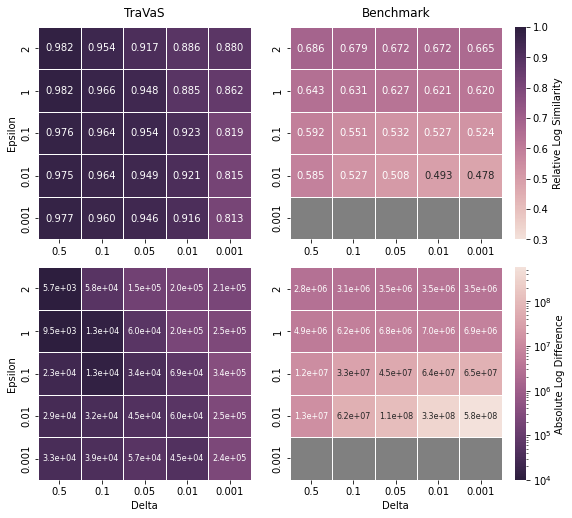

In [3]:
# load final data
util_single = np.loadtxt('single/util_single.txt')
util_multi = np.loadtxt('multi/util_multi.txt')
util_bench = np.loadtxt('benchmark/util_bench.txt')

cost_single = np.loadtxt('single/cost_single.txt')
cost_multi = np.loadtxt('multi/cost_multi.txt')
cost_bench = np.loadtxt('benchmark/cost_bench.txt')

util_best = np.maximum(util_single, util_multi)
util_bench = np.vstack([util_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
cost_best = np.minimum(cost_single, cost_multi)
cost_bench = np.vstack([cost_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap_r = sns.cubehelix_palette(as_cmap=True, light=.9, reverse=True)
cmap.set_bad('grey', 1.)
cmap_r.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(util_best, ax=ax[0,0], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(util_bench, ax=ax[0,1], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Relative Log Similarity'})
ax[1,0] = sns.heatmap(cost_best, ax=ax[1,0], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, annot_kws={"fontsize":8})
ax[1,1] = sns.heatmap(cost_bench, ax=ax[1,1], cmap=cmap_r, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), square=True, annot=True, fmt='.1e', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Absolute Log Difference'}, annot_kws={"fontsize":8})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()
plt.savefig("BPIC13_1.pdf")

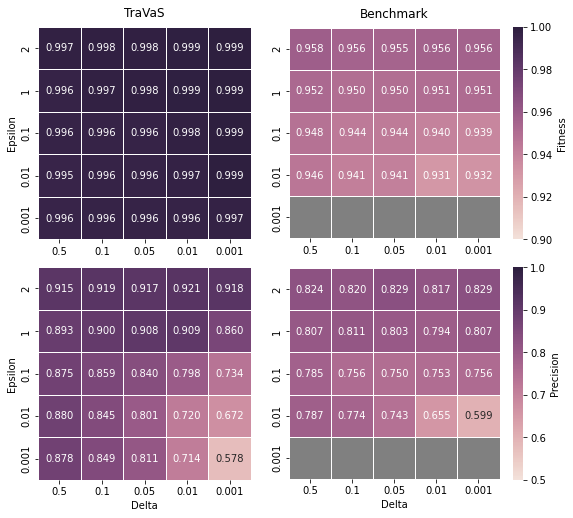

In [4]:
# load final data
prec_single = np.loadtxt('single/prec_single.txt')
prec_multi = np.loadtxt('multi/prec_multi.txt')
prec_bench = np.loadtxt('benchmark/prec_bench.txt')
prec_bench = np.vstack([prec_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
prec_best = np.maximum(prec_single, prec_multi)

fit_single = np.loadtxt('single/fit_single.txt')
fit_multi = np.loadtxt('multi/fit_multi.txt')
fit_bench = np.loadtxt('benchmark/fit_bench.txt')
fit_bench = np.vstack([fit_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
fit_best = np.maximum(fit_single, fit_multi)

gen_single = np.loadtxt('single/gen_single.txt')
gen_multi = np.loadtxt('multi/gen_multi.txt')
gen_bench = np.loadtxt('benchmark/gen_bench.txt')
gen_bench = np.vstack([gen_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
gen_best = np.maximum(gen_single, gen_multi)

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_best, ax=ax[0,0], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(fit_bench, ax=ax[0,1], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_best, ax=ax[1,0], cmap=cmap, square=True, vmin=0.5, vmax=1, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[1,1] = sns.heatmap(prec_bench, ax=ax[1,1], cmap=cmap, vmin=0.5, vmax=1, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Precision'})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()
plt.savefig("BPIC13_2.pdf")